# Error Analysis of Sentiment Classification Model

In this notebook, we will analyze the errors made by our fine-tuned DistilBERT-base model on a sentiment classification task using a dataset of news headlines and their associated sentiment labels.

The model contains the following improvement compared to the ALBERT training run:

- Implemented label smoothing.
- Extended the dataset with data augmentation.
- The model itself is explicitly trained on uncased data.

In [1]:
# To allow importing modules from src
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification, AutoTokenizer, PreTrainedModel

from helpers import SentimentDataset, SENTIMENT_TO_ID, ID_TO_SENTIMENT, load_model

### Load the pre-trained model and tokenizer

In [3]:
BATCH_SIZE = 100
MODEL_NAME = 'distilbert-base-uncased'
TIME = '2023-05-05 18-33-22'

model_path = f'../../models/{MODEL_NAME} {TIME}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding="max_length", truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=ID_TO_SENTIMENT, label2id=SENTIMENT_TO_ID
)

model = load_model(model, model_path, device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

### Load and preprocess the dataset

In [5]:
def collate_batch(batch, tokenizer, max_length=25):
    """Process a batch of data to its proper form."""
    # Feature should be batch_size * num_words * num_vocabs
    features, labels = zip(*batch)
    features = tokenizer(features, add_special_tokens=True, max_length=max_length, 
                         padding="max_length", truncation=True, return_tensors="pt")
    labels = torch.stack(labels)
    return features, labels

In [6]:
# Read the dataset
train_data = SentimentDataset('../../data/fixed-data/sentiment-train.csv')
test_data = SentimentDataset('../../data/fixed-data/sentiment-val.csv')

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda x: collate_batch(x, tokenizer))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=lambda x: collate_batch(x, tokenizer))

### Evaluate the model

In [7]:
def get_predictions(model, data_loader, device='cpu'):
    """Get predictions from the model and targets on the data_loader."""
    model.eval()
    all_outputs = []
    all_targets = []
    for features, target in data_loader:
        features = features.to(device=device)
        target = target.to(device=device)
        
        # One-hot encode targets
        if isinstance(model, PreTrainedModel):
            output = model(**features, labels=target).logits
        else:
            output = model(features)
            if isinstance(output, tuple):
                output = output[0]
                
        target = torch.nn.functional.one_hot(target, num_classes=3)
        output = output.detach().to('cpu')
        target = target.detach().to('cpu')
        all_outputs.append(output)
        all_targets.append(target)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    return all_outputs, all_targets


output, target = get_predictions(model, test_loader, device=device)

In [8]:
def _classification_report(output, target):
    probs = torch.nn.functional.softmax(output, dim=1)
    preds = probs.argmax(dim=1)
    target = target.argmax(dim=1)
    report = classification_report(target, preds, output_dict=True, 
                                   target_names=ID_TO_SENTIMENT.values())
    report = pd.DataFrame(report)
    cols = ['Negative', 'Neutral', 'Positive', 'weighted avg']
    rows = ['precision', 'recall', 'f1-score']
    return report.loc[rows, cols].transpose()


def _baseline_accuracy(target):
    counter = target.sum(axis=0)
    counter = (counter/ counter.sum())
    
    baseline_acc = pd.DataFrame(counter, columns=['Baseline Accuracy'], index=ID_TO_SENTIMENT.values())
    baseline_acc.loc['weighted avg'] = counter.max().item()
    return baseline_acc


def _accuracy(output, target):
    probs = torch.nn.functional.softmax(output, dim=1)
    preds = probs.argmax(dim=1)
    preds = torch.nn.functional.one_hot(preds, num_classes=3)
    accuracy = (preds * target).sum(axis=0) / target.sum(axis=0)
    acc = pd.DataFrame(accuracy, columns=['Accuracy'], index=ID_TO_SENTIMENT.values())
    acc.loc['weighted avg'] = acc.mean().item()
    return acc


def compute_metrics(output, target):
    cls_report = _classification_report(output, target)
    baseline_accuracy = _baseline_accuracy(target)
    accuracy = _accuracy(output, target)
    cls_report = pd.concat([baseline_accuracy, accuracy, cls_report], axis=1)
    return cls_report

cls_report = compute_metrics(output, target)
cls_report

,Baseline Accuracy,Accuracy,precision,recall,f1-score
Negative,0.319211,0.944952,0.942696,0.944952,0.943823
Neutral,0.364565,0.915031,0.918005,0.915031,0.916516
Positive,0.316224,0.930595,0.929370,0.930595,0.929982
weighted avg,0.364565,0.930193,0.929480,0.929504,0.929491


### Analyze misclassified samples

In [9]:
def get_missclassified_indices(output, target):
    output = torch.nn.functional.softmax(output, dim=1)
    miscls_data = (output.argmax(dim=1) != target.argmax(dim=1))
    misclassified_indices = miscls_data.nonzero(as_tuple=True)[0]
    return misclassified_indices.numpy()


def dataset_to_df(dataset):
    df = pd.DataFrame(tuple(dataset), columns=['Headlines', 'Sentiment'])
    df['Sentiment'] = df['Sentiment'].apply(lambda x: x.item())
    return df

def create_missclassification_df(dataset, output, target):
    df = dataset_to_df(dataset)
    misclassified_indices = get_missclassified_indices(output, target)
    df = df.iloc[misclassified_indices].copy()

    df['Predicted'] = output.argmax(dim=1)[misclassified_indices].numpy()
    df['Sentiment'] = df['Sentiment'].map(ID_TO_SENTIMENT)
    df['Predicted'] = df['Predicted'].map(ID_TO_SENTIMENT)
    return df

In [10]:
misclassified_samples = create_missclassification_df(test_data, output, target)

for _, row in misclassified_samples.sample(10).iterrows():
    print(f"Headline: {row['Headlines']}"
          f"\nTrue sentiment: {row['Sentiment']}, "
          f"Model prediction: {row['Predicted']}\n")

Headline: billionaire industrialist and conservative donor david koch dies at age 79
True sentiment: Negative, Model prediction: Neutral

Headline: prospect come after pricing an added 21 mil shares
True sentiment: Negative, Model prediction: Positive

Headline: spot gold quoted at 404.10 in asia trade
True sentiment: Positive, Model prediction: Neutral

Headline: instant view new home sales resurrect 3.6 percet in july, but prices fall
True sentiment: Positive, Model prediction: Negative

Headline: ftc approves ge purchase of avio s aviation business
True sentiment: Positive, Model prediction: Neutral

Headline: swedbank to raise cap, riksbank helps carnegie
True sentiment: Positive, Model prediction: Neutral

Headline: nokia to commencement mobile financial service
True sentiment: Positive, Model prediction: Neutral

Headline: use reveals connection between financial savviness survey of digital banking tools
True sentiment: Positive, Model prediction: Neutral

Headline: top five etfs

In [11]:
# write misclassified samples to csv
if not os.path.exists('../../data/misclassified-samples'):
    os.makedirs('../../data/misclassified-samples')

file_path = f'../../data/misclassified-samples/{MODEL_NAME} {TIME}.csv'
if not os.path.exists(file_path):
    train_output, train_target = get_predictions(model, train_loader, device=device) 
    df = create_missclassification_df(train_data, train_output, train_target)
    df.to_csv(file_path, index=False)
else:
    df = pd.read_csv(file_path, index_col=False)

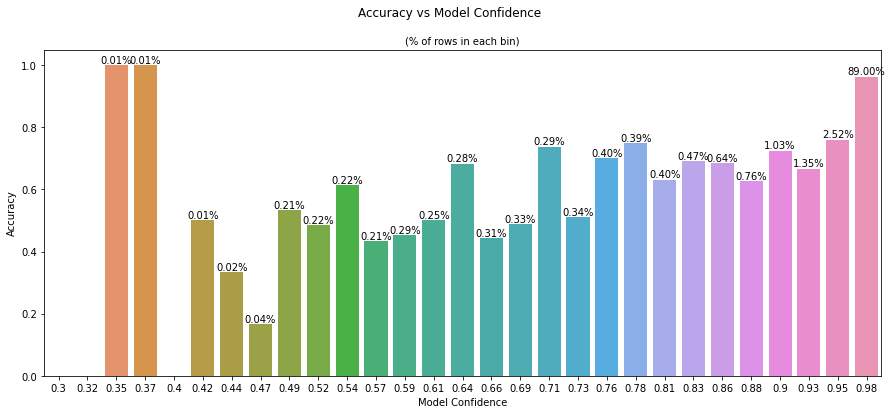

In [12]:
probs = torch.softmax(output, dim=1).numpy()
confidence = np.max(probs, axis=1)
target_labels = np.argmax(target.numpy(), axis=1)
correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

# Calculate error rate per confidence interval
confidence_intervals = np.linspace(0.3, 1, 30)
accuracy = []
row_percentage = []
for i in range(len(confidence_intervals) - 1):
    mask = (confidence >= confidence_intervals[i]) & (confidence < confidence_intervals[i + 1])
    if np.sum(mask) > 0:
        accuracy.append(np.mean(correct_preds[mask]))
        row_percentage.append(np.sum(mask) / len(confidence) * 100)
    else:
        accuracy.append(np.nan)
        row_percentage.append(0)

# Plot error rate vs. model confidence
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=np.round(confidence_intervals[:-1], 2), y=accuracy)

# Annotate bars with the percentage of rows in each bin
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{row_percentage[i]:.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("Model Confidence")
plt.ylabel("Accuracy")
plt.suptitle("Accuracy vs Model Confidence")
plt.title("(% of rows in each bin)", fontsize=10)
plt.show()

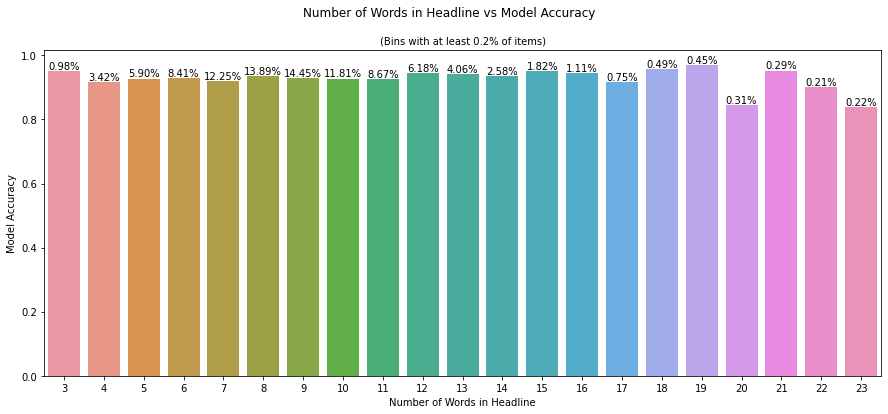

In [13]:
probs = torch.softmax(output, dim=1).numpy()
confidence = np.max(probs, axis=1)
target_labels = np.argmax(target.numpy(), axis=1)
correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

df = dataset_to_df(test_data)
df['word_count'] = df['Headlines'].apply(lambda x: len(x.split()))
df['is_correct'] = (correct_preds).astype(int)

word_count_accuracy = df.groupby('word_count')['is_correct'].mean().reset_index()
# Calculate the percentage of rows for each word count bin
word_count_percentage = df.groupby('word_count')['is_correct'].count().reset_index()
word_count_percentage['percentage'] = (word_count_percentage['is_correct'] / df.shape[0]) * 100

# Merge accuracy and percentage data
word_count_data = pd.merge(word_count_accuracy, word_count_percentage, on='word_count', suffixes=('_accuracy', '_count'))
word_count_data_filtered = word_count_data[word_count_data['percentage'] >= 0.2]

# Create the bar plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='word_count', y='is_correct_accuracy', data=word_count_data_filtered)
# Add annotations to the plot
for i, p in enumerate(ax.patches):
    percentage = word_count_data_filtered.iloc[i]['percentage']
    ax.annotate(
        f"{percentage:.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
    )

plt.xlabel('Number of Words in Headline')
plt.ylabel('Model Accuracy')
plt.suptitle('Number of Words in Headline vs Model Accuracy')
plt.title('(Bins with at least 0.2% of items)', fontsize=10)
plt.show()

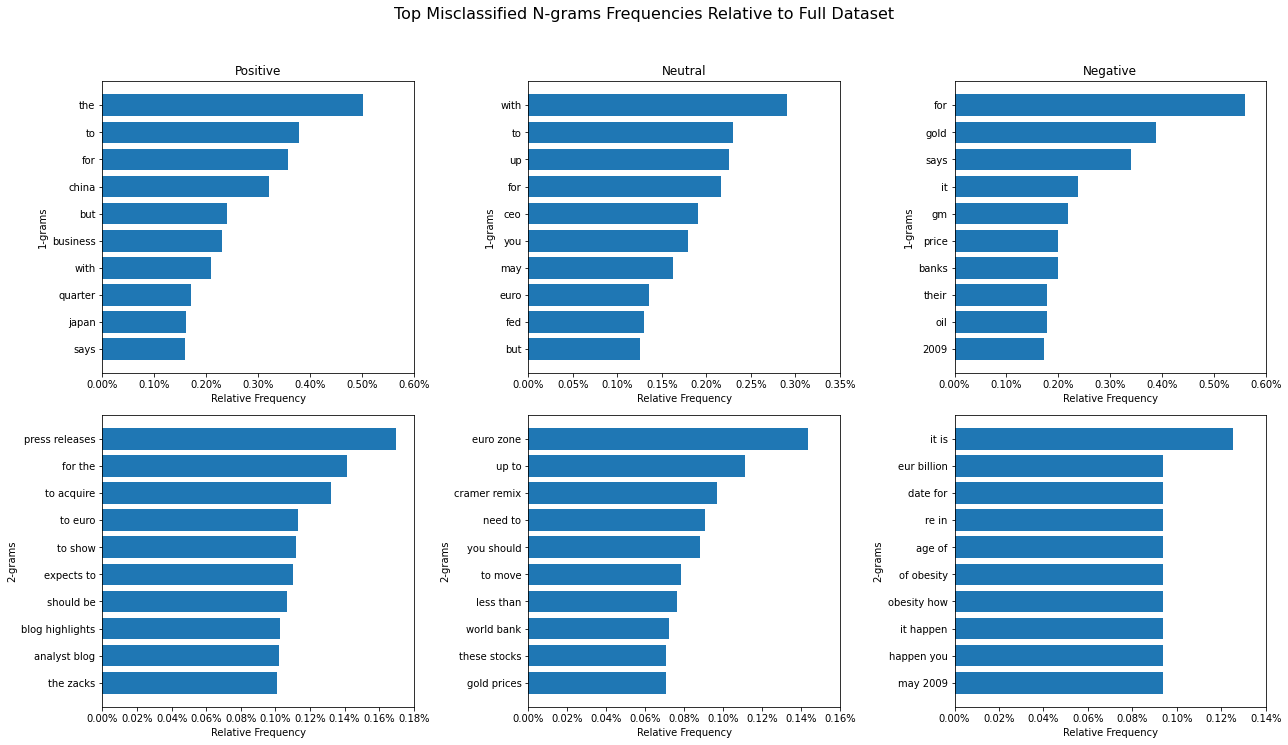

In [14]:
# Plot the distribution of word counts of misclassified samples vs. all samples for each sentiment
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies


def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all sentiments.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])

total_1ngrams = get_ngrams(df['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(df['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

unique_sentiments = ['Positive', 'Neutral', 'Negative']
num_sentiments = len(unique_sentiments)
fig, axes = plt.subplots(2, num_sentiments, figsize=(6 * num_sentiments, 10))

for col, sentiment in enumerate(unique_sentiments):
    mask = df['Sentiment'] == SENTIMENT_TO_ID[sentiment]
    missclassified_headlines = df[mask & (df['is_correct'] == 0)]['Headlines']

    axes[0, col].set_title(sentiment)
    plot_top_ngrams_relative(axes[0, col], missclassified_headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], missclassified_headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top Misclassified N-grams Frequencies Relative to Full Dataset', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

### Conclusion

- The model does no longer struggle with neutral sentiment
- Model smoothing not working as expected,
- There is no relationship between headline word length and prediction accuracy
- There is no obvious relationship between ngrams and prediction errors.

### Calibrating Model Prediction Probabilities

In [29]:
from sklearn.linear_model import LogisticRegression


def fit_logistic_regression(logits, labels, class_idx):
    """
    Fits a logistic regression model for a specific class in a one-vs-rest setting.
    
    Args:
        logits (torch.Tensor): The logits (pre-softmax outputs) of the model for the validation dataset.
            Shape: (num_samples, num_classes).
        labels (torch.Tensor): The ground truth labels for the validation dataset (one-hot encoded).
            Shape: (num_samples, num_classes).
        class_idx (int): The index of the class for which the logistic regression model is being fit.

    Returns:
        sklearn.linear_model.LogisticRegression: A fitted logistic regression model for the specified class.
    """
    logits = logits.numpy()
    labels = labels.argmax(dim=1)
    binary_labels = (labels == class_idx).float().numpy()
    logistic_regression = LogisticRegression(solver='lbfgs')
    logistic_regression.fit(logits, binary_labels)
    return logistic_regression


def calibrate_predictions(logits, logistic_models):
    """
    Calibrates the model using Platt scaling with fitted logistic regression models.

    Args:
        logits (torch.Tensor): The logits (pre-softmax outputs) of the model for a test dataset.
            Shape: (num_samples, num_classes).
        logistic_models (list): A list of fitted logistic regression models, one for each class in a
            one-vs-rest setting.

    Returns:
        torch.Tensor: Calibrated probabilities for the test dataset, shape: (num_samples, num_classes).
    """
    calibrated_probs = [logistic_models[i].predict_proba(logits.numpy())[:, 1] for i in range(num_classes)]
    calibrated_probs_tensor = torch.tensor(calibrated_probs).T
    return calibrated_probs_tensor / torch.sum(calibrated_probs_tensor, dim=1, keepdim=True)

num_classes = 3
logistic_models = [fit_logistic_regression(output, target, class_idx) for class_idx in range(num_classes)]

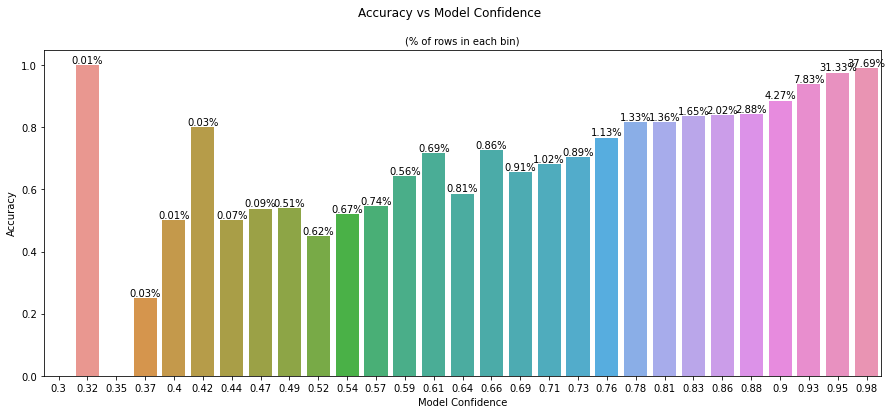

In [30]:
probs = calibrate_predictions(output, logistic_models).numpy()
confidence = np.max(probs, axis=1)
target_labels = np.argmax(target.numpy(), axis=1)
correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

# Calculate error rate per confidence interval
confidence_intervals = np.linspace(0.3, 1, 30)
accuracy = []
row_percentage = []
for i in range(len(confidence_intervals) - 1):
    mask = (confidence >= confidence_intervals[i]) & (confidence < confidence_intervals[i + 1])
    if np.sum(mask) > 0:
        accuracy.append(np.mean(correct_preds[mask]))
        row_percentage.append(np.sum(mask) / len(confidence) * 100)
    else:
        accuracy.append(np.nan)
        row_percentage.append(0)

# Plot error rate vs. model confidence
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=np.round(confidence_intervals[:-1], 2), y=accuracy)

# Annotate bars with the percentage of rows in each bin
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{row_percentage[i]:.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("Model Confidence")
plt.ylabel("Accuracy")
plt.suptitle("Accuracy vs Model Confidence")
plt.title("(% of rows in each bin)", fontsize=10)
plt.show()